# PROYECTO TOPIC MODELLING NLP-4

In [ ]:
#Install
#!pip install pyLDAvis -qq
#!pip install -qq -U gensim
#!pip install spacy -qq
#!pip install matplotlib -qq
#!pip install seaborn -qq
#!python -m spacy download es_core_news_sm -qq
#!pip install clean-text

In [137]:
#Imports
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import es_core_news_sm
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from unicodedata import normalize
import cleantext


c:\Users\Altux\anaconda3\envs\NLP\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\Altux\anaconda3\envs\NLP\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [208]:
# Leemos solo un fragmento del dump de Wikipedia Español
reports = pd.read_xml('C:/Users/Altux/OneDrive/Escritorio/eswiki-20220620-pages-articles-multistream1.xml', xpath='//revision')

In [209]:
# Columnas y primeras filas del DataFrame que representa el dump de Wikipedia
reports.head()
#reports.info()

,id,parentid,timestamp,contributor,comment,model,format,text,sha1,minor
0,132533307,132516631.0,2021-01-19T18:40:34Z,NaN,Así esta mejor,wikitext,text/x-wiki,{{atajos|[[WP:AS]]|[[WP:SOL]]}}\n{{Wikipedia:A...,0rib3p60ihvh0mc8mystql47lmzzla1,NaN
1,144231063,144230963.0,2022-06-16T15:11:21Z,NaN,Revertidos los cambios de [[Special:Contributi...,wikitext,text/x-wiki,{{otros usos}} \n{{Ficha de país\n| nombre_ofi...,q1ptmgg14eammf9xz7bm1xoaoxh44h9,NaN
2,144288170,144288110.0,2022-06-19T17:01:49Z,NaN,Revertidos los cambios de [[Special:Contributi...,wikitext,text/x-wiki,{{Artículo destacado}}\n{{Otros usos|Argentina...,j6zcokn8en8axmgqpnt4fobm3r2gtat,NaN
3,143582359,141544565.0,2022-05-16T19:38:55Z,NaN,Reemplazos con [[Usuario:Benjavalero/Replacer|...,wikitext,text/x-wiki,{{Ficha de geografía\n|Image ...,evoxbj96hu4l0ivh329yav891ybjh97,NaN
4,143123328,142576894.0,2022-04-25T11:04:23Z,NaN,Actualizo tablas,wikitext,text/x-wiki,[[Andorra]] cuenta con 76.966 habitantes y una...,a35r43opjwqpwc9tymd81l2zld1iinc,NaN


In [210]:
# Dimensiones del dataframe, mas de 70k articulos
reports.shape

(70711, 10)

In [211]:
# Obtenemos solo los primeros 1500 articulos y solo las columnas de ID y Text
reports = reports.iloc[0:1500, [0,7]]

# Convertimos la coluna text a tipo de dato string por rendimiento 
reports = reports['text'].astype('string')
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1500 non-null   string
 1   text    1500 non-null   string
dtypes: string(2)
memory usage: 23.6 KB


In [212]:
# Cargamos el modelo de spaCy basico de Español:
nlp = es_core_news_sm.load()

In [213]:
# Mostramos solo un articulo (indice 4) para observar como vienen el texto
reports.text[4]

'[[Andorra]] cuenta con 76.966 habitantes y una densidad de población de 170 hab./km², según el censo de [[2017]]. Debido a una política restrictiva de concesión de la nacionalidad, la población de nacionalidad andorrana solo constituye el 36,6% de los habitantes del país; el resto de la población, aun siendo mayoritaria, no dispone de derechos políticos.\n\n== Nacionalidades y evolución demográfica ==\nSegún el censo de [[2008]], el 36,6% de la población del país (30.442 habitantes) es de nacionalidad andorrana, el 33,0% (27.476 hab.) es de nacionalidad [[España|española]], el 16,2% (13.518 hab.) es de nacionalidad [[Portugal|portuguesa]], el 6,2% (5.200 hab.) es de nacionalidad [[Francia|francesa]], y el 7,8% restante (6.502 hab.) es de otras nacionalidades.<ref name="Estadística">[https://web.archive.org/web/20081118141736/http://www.estadistica.ad/indexdee.htm Estadísticas de población de Andorra.] Ministerio de Justicia e Interior de Andorra</ref>\n{| class="wikitable" width=25% s

In [214]:
# Convertimos el text a una lista
data = reports.text.values.tolist()

# Eliminar newlines y otros caracteres de espacios
data = [re.sub(r'\s+', ' ', sent) for sent in data]

# Eliminar tags HTML
CLEANR = re.compile('<.*?>')
data = [re.sub(CLEANR, '', sent) for sent in data]

In [215]:
# Quitar tildes
data = [re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", sent), 0, re.I
    ) for sent in data]

data = [normalize('NFC', sent) for sent in data]

In [216]:
# Quitar URLs
data = [cleantext.replace_urls(sent, replace_with="") for sent in data]

In [217]:
# Quitar Propiedades de configuracion
aligns = re.compile('(align|text-align)[=](center|left|right)')
data = [re.sub(aligns, '', sent) for sent in data]

aligns = re.compile('(align|text-align)[=]["](center|left|right)["]')
data = [re.sub(aligns, '', sent) for sent in data]

In [218]:
# Quitarmos palabras comunes propias de Wiki
wikiwords = re.compile('(left|right|width|class|align|style|background|Archivo|font|weight|bold|size|colspan|urlarchivo|fechaarchivo|deadurl|fechaacceso|bgcolor|listaref|wikitable|thumb)')
data = [re.sub(wikiwords, '', sent) for sent in data]

In [219]:
# Mostramos un ejemplo del resultado de la limpieza del texto
data[4]

'[[Andorra]] cuenta con 76.966 habitantes y una densidad de poblacion de 170 hab./km², segun el censo de [[2017]]. Debido a una politica restrictiva de concesion de la nacionalidad, la poblacion de nacionalidad andorrana solo constituye el 36,6% de los habitantes del pais; el resto de la poblacion, aun siendo mayoritaria, no dispone de derechos politicos. == Nacionalidades y evolucion demografica == Segun el censo de [[2008]], el 36,6% de la poblacion del pais (30.442 habitantes) es de nacionalidad andorrana, el 33,0% (27.476 hab.) es de nacionalidad [[España|española]], el 16,2% (13.518 hab.) es de nacionalidad [[Portugal|portuguesa]], el 6,2% (5.200 hab.) es de nacionalidad [[Francia|francesa]], y el 7,8% restante (6.502 hab.) es de otras nacionalidades.[ Estadisticas de poblacion de Andorra.] Ministerio de Justicia e Interior de Andorra {| ="" =25% ="float:; margin-:8px" |+ Evolucion demografica de Andorra[ Departament d\'Estadistica] (2010-2021) |- !=15% |Año !=40% |Pob. total !=30

In [220]:
# Tags del Part of Speech que quiero eliminar 
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

# Tokenizacion y Lematizacion
tokens = []
for summary in nlp.pipe(data):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [222]:
# Se agregan los tokens a una nueva columna del Dataframe y se muestra un pequeño fragmento
reports['tokens'] = tokens
reports['tokens'][4]

['andorra',
 'habitante',
 'densidad',
 'poblacion',
 'censo',
 'politica',
 'restrictivo',
 'concesion',
 'nacionalidad',
 'poblacion',
 'nacionalidad',
 'andorrano',
 'constituir',
 'habitante',
 'pais',
 'resto',
 'poblacion',
 'mayoritario',
 'disponer',
 'derecho',
 'politico',
 'nacionalidades',
 'evolucion',
 'demografico',
 'censo',
 'poblacion',
 'pais',
 'habitante',
 'nacionalidad',
 'andorrano',
 'hab',
 'nacionalidad',
 'hab',
 'nacionalidad',
 'hab',
 'nacionalidad',
 'restante',
 'hab',
 'nacionalidad',
 'estadisticas',
 'poblacion',
 'andorra',
 'ministerio',
 'justicia',
 'interior',
 'andorra',
 'float',
 'evolucion',
 'demografico',
 'andorra',
 'departament',
 'nacionalidad',
 'andorrano',
 'nacionalidad',
 'andorrano',
 'nacionalidad',
 'español',
 'nacionalidad',
 'español',
 'nacional',
 'andorrano',
 'minorio',
 'pais',
 'formar',
 'poblacion',
 'factor',
 'andorra',
 'situado',
 'zona',
 'aislado',
 'densidad',
 'poblacion',
 'bajo',
 'condicion',
 'paraiso',
 

In [223]:
# Dataframe listo
reports

,id,text,tokens
0,132533307,{{atajos|[[WP:AS]]|[[WP:SOL]]}} {{Wikipedia:Ar...,"[sol, wikipedia, articulos, solicitado, solici..."
1,144231063,{{otros usos}} {{Ficha de país | nombre_ofici...,"[uso, ficha, pais, principado, andorra, nombre..."
2,144288170,{{Artículo destacado}} {{Otros usos|Argentina ...,"[articulo, destacado, argentino, desambiguacio..."
3,143582359,{{Ficha de geografía |Image ...,"[ficha, geografia, andorra, europa, europa, me..."
4,143123328,[[Andorra]] cuenta con 76.966 habitantes y una...,"[andorra, habitante, densidad, poblacion, cens..."
...,...,...,...
1495,144206460,{{Distinguir|Optimismo|Positivismo lógico}} [[...,"[logico, auguste, comte, fundador, doctrina, p..."
1496,23715405,{{Museo}} Existen varios motivos interesantes ...,"[museo, motivo, interesante, involucrar él, wi..."
1497,142940278,[[Archivo:Kopp-op5-1.png|thumb|300px|'''Figura...,"[partitura, partitura, documento, manuscrito, ..."
1498,142560025,"La '''programación dirigida por eventos''', es...","[programacion, dirigido, evento, paradigma, pr..."


In [240]:
# Se crea el diccionario de palabras
# Se aplica el objeto de Gensim: Dictionary, que mapea cada palabra a su ID unico.
dictionary = Dictionary(reports['tokens'])

#print(dictionary.token2id)

In [241]:
# Se filtra el dictionario
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=55000)

In [242]:
# Se muestran todas las palabras del diccionario
for key, value in dictionary.items():
    print(key, value)

0 africa
1 aragon
2 arte
3 articulo
4 articulos
5 britanica
6 ciencias
7 color
8 corona
9 deportes
10 disponer
11 encarta
12 enciclopedia
13 enlace
14 español
15 faltar
16 humanidad
17 humanidades
18 interno
19 juridica
20 listas
21 mejorar
22 miscelanea
23 pais
24 palabra
25 patrimonio
26 plantilla
27 portal
28 proyecto
29 puro
30 relacionado
31 seccion
32 separado
33 social
34 sol
35 solicitado
36 solicitar
37 tecnologia
38 tematica
39 tener
40 tratar
41 usuario
42 vigilar
43 wikipedia
44 wikiproyecto
45 aaa
46 abandonar
47 abonado
48 abril
49 abrir
50 absoluto
51 abundante
52 abundar
53 acabar
54 academia
55 acb
56 acceder
57 acceso
58 aceptado
59 aceptar
60 acompañar
61 acord
62 acta
63 actitud
64 actividad
65 activo
66 actual
67 actualidad
68 actualizacion
69 actualizado
70 actuar
71 acuñar
72 ad
73 adecuacion
74 adherido
75 adjuntar
76 administracion
77 administrativo
78 adolescente
79 adolf
80 adoptar
81 adopto
82 adquirido
83 adquirir
84 adquisicion
85 adrian
86 aeropuerto
87 a

In [257]:
# Se crea el corpus y se muestra el primer documento que es un bag of words
corpus = [dictionary.doc2bow(doc) for doc in reports['tokens']]
corpus[0]

[(0, 2),
 (1, 2),
 (2, 1),
 (3, 2),
 (4, 16),
 (5, 1),
 (6, 4),
 (7, 7),
 (8, 2),
 (9, 1),
 (10, 1),
 (11, 2),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 2),
 (26, 1),
 (27, 3),
 (28, 4),
 (29, 1),
 (30, 1),
 (31, 7),
 (32, 1),
 (33, 2),
 (34, 1),
 (35, 20),
 (36, 1),
 (37, 1),
 (38, 3),
 (39, 1),
 (40, 1),
 (41, 3),
 (42, 7),
 (43, 17),
 (44, 4)]

In [244]:
# Se construye el modelo LDA inicial con hiperparametros default, este modelo se puede usar con varios nucleos de procesador
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 8, passes=10)

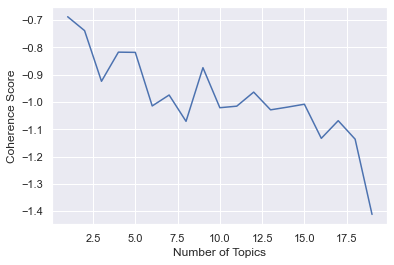

In [245]:
# Metrica de Coherencia usando C_umass:
topics0 = []
score0 = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 8, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics0.append(i)
   score0.append(cm.get_coherence())
_=plt.plot(topics0, score0)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [281]:
# Se orden las metricas de cada numero de topicos para saber cual es el mas alto puntaje
metricas0 = {'Topics': topics0, 'Scores': score0}
metricasDf0 = pd.DataFrame(metricas0)
metricasDf0.sort_values(by=['Scores'], ascending=False)

,Topics,Scores
16,17,0.534221
10,11,0.517874
17,18,0.515603
14,15,0.514352
8,9,0.512896
13,14,0.509915
15,16,0.500521
9,10,0.495773
11,12,0.493076
12,13,0.491356


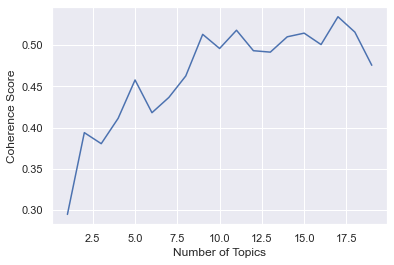

In [246]:
# Metrica de Coherencia usando C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 8, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = reports['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [280]:
# Se orden las metricas de cada numero de topicos para saber cual es el mas alto puntaje
metricas = {'Topics': topics, 'Scores': score}
metricasDf = pd.DataFrame(metricas)
metricasDf.sort_values(by=['Scores'], ascending=False)

,Topics,Scores
16,17,0.534221
10,11,0.517874
17,18,0.515603
14,15,0.514352
8,9,0.512896
13,14,0.509915
15,16,0.500521
9,10,0.495773
11,12,0.493076
12,13,0.491356


In [252]:
# Modelo optimo, se elige numero de topicos = 9 por su posisionamiento en ambas metricas cu_mass y c_v
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=9, workers = 8, passes=100)

In [253]:
# Se imprimen los topicos
lda_model.print_topics(-1)

[(0,
  '0.007*"ciudad" + 0.007*"web" + 0.006*"españa" + 0.006*"provincia" + 0.006*"nacional" + 0.006*"año" + 0.005*"pais" + 0.005*"san" + 0.004*"poblacion" + 0.004*"gobierno"'),
 (1,
  '0.008*"año" + 0.008*"obra" + 0.005*"libro" + 0.005*"ingl" + 0.005*"pelicula" + 0.004*"web" + 0.004*"novela" + 0.003*"literatura" + 0.003*"historia" + 0.003*"cine"'),
 (2,
  '0.012*"lengua" + 0.011*"idioma" + 0.007*"español" + 0.006*"derecho" + 0.005*"guerra" + 0.005*"país" + 0.004*"juego" + 0.004*"mundial" + 0.004*"mundo" + 0.004*"francia"'),
 (3,
  '0.016*"familia" + 0.016*"genero" + 0.015*"especie" + 0.013*"world" + 0.009*"planta" + 0.008*"image" + 0.008*"grass" + 0.007*"flor" + 0.007*"poaceae" + 0.006*"flora"'),
 (4,
  '0.011*"libro" + 0.009*"jesus" + 0.009*"dios" + 0.006*"iglesia" + 0.005*"cristiano" + 0.005*"citar" + 0.004*"evangelio" + 0.004*"año" + 0.004*"university" + 0.004*"cita"'),
 (5,
  '0.009*"sistema" + 0.008*"numero" + 0.006*"web" + 0.004*"lenguaje" + 0.004*"ejemplo" + 0.004*"codigo" + 0.

### Temas de cada Topico
1. Geografia
2. Cine / Literatura 
3. Historia
4. Botanica
5. Cristianismo
6. Tecnologia de informacion
7. Teoria de Evolucion
8. Premios Cinematograficos
9. Ciencias

In [282]:
# Articulo 1000 Compresion de Imagenes digitales
reports['text'][1000]

'{{Referencias|t=20180621142211}}\n{{Ficha de formato de archivo\n|nombre          = JPEG \n|icono           = \n|captura         = [[Archivo:Phalaenopsis JPEG.png|240px]]\n|pie             = Foto de una flor comprimida gradualmente con el formato JPEG.\n|extensión       = .jpeg</tt>, <tt>.jpg</tt>, <tt>.jpe</tt><br /><tt>.jfif</tt>, <tt>.jfi</tt>, <tt>.jif</tt> (contenedores)\n|MIME            = image/jpeg\n|type_code       = JPEG\n|uniform_type    = public.jpeg\n|número_mágico   = ff d8\n|desarrollador   = \'\'Joint Photographic Experts Group\'\'\n|género          = [[Formatos gráficos|Gráficos]] con [[Algoritmo de compresión con pérdida|compresión con pérdida]]\n|contenedor_para = \n|contenido_por   = \n|extendido_de    = \n|extendido_a     = \n|estándar        = \n}}\n\n\'\'\'Joint Photographic Experts Group\'\'\' (\'\'\'JPEG\'\'\') es el nombre de un comité de expertos que creó un [[Norma (tecnología)|estándar]] de [[Compresión de datos|compresión]] y [[Codificación digital|codifi

In [275]:
# Se muestra un ejemplo de clasificacion usando el indice 1000 (articulo/documento) el cual lo clasifica como el topico 5 (Tecnologia de la Informacion)
lda_model[corpus[1000]]

[(5, 0.9990085)]

In [255]:
# Se visualizan los topicos de una manera muy grafica e iteractiva
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

c:\Users\Altux\anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [256]:
# Se guarda el reporte en formato html
pyLDAvis.save_html(lda_display, 'index.html')